In [ ]:
!pip install facenet_pytorch

In [1]:
import kagglehub
import os
import cv2
import numpy as np
from tqdm import tqdm
from facenet_pytorch import MTCNN
from glob import glob
import shutil

# Download Celeb-DF V2 dataset
dataset_path = kagglehub.dataset_download("reubensuju/celeb-df-v2")
print("Dataset downloaded to:", dataset_path)

100%|██████████| 9.29G/9.29G [01:52<00:00, 88.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1


In [3]:
!mv /root/.cache/kagglehub/datasets/reubensuju/celeb-df-v2/versions/1 /content/celeb-df-v2

In [2]:
# Correct dataset path
dataset_path = "/content/celeb-df-v2"

# Define directories
video_dir = dataset_path  # The root folder already contains subfolders

output_dir = "/content/Celeb-DF-Processed"
os.makedirs(output_dir, exist_ok=True)

# Update real and fake directories based on the dataset structure
real_dir = os.path.join(output_dir, "Celeb-real")
fake_dir = os.path.join(output_dir, "Celeb-synthesis")

os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

In [4]:
import cv2
import os
import numpy as np
import torch
from glob import glob
from tqdm import tqdm
from facenet_pytorch import MTCNN

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=False, post_process=False, device=device)

def extract_faces(video_path, save_dir, frames_per_video=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    selected_frames = np.linspace(0, frame_count - 1, frames_per_video, dtype=int)

    for frame_num in selected_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        success, frame = cap.read()
        if not success:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = mtcnn.detect(frame_rgb)

        if boxes is not None and len(boxes) > 0:
            x1, y1, x2, y2 = map(int, boxes[0])
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(frame.shape[1], x2), min(frame.shape[0], y2)
            face_crop = frame_rgb[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue

            face_resized = cv2.resize(face_crop, (224, 224))
            file_name = f"{os.path.basename(video_path).split('.')[0]}_{frame_num}.jpg"
            cv2.imwrite(os.path.join(save_dir, file_name), cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))

    cap.release()

def process_videos(video_list, save_dir, start_fraction=0, end_fraction=0.25):
    total_videos = len(video_list)
    start_idx = int(total_videos * start_fraction)
    end_idx = int(total_videos * end_fraction)
    selected_videos = video_list[start_idx:end_idx]

    print(f"Processing {len(selected_videos)} videos from index {start_idx} to {end_idx}...")
    for video in tqdm(selected_videos, desc=f"Processing {save_dir}"):
        extract_faces(video, save_dir)

# Define dataset directories

real_videos = glob(os.path.join(video_dir, "Celeb-real", "*.mp4")) + \
              glob(os.path.join(video_dir, "YouTube-real", "*.mp4"))
fake_videos = glob(os.path.join(video_dir, "Celeb-synthesis", "*.mp4"))

# Process only the first quarter
process_videos(real_videos, real_dir, start_fraction=0, end_fraction=0.25)
process_videos(fake_videos, fake_dir, start_fraction=0, end_fraction=0.25)

print(f"\nPreprocessing completed for the selected quarter.")

Using device: cuda
Processing 222 videos from index 0 to 222...


Processing /content/Celeb-DF-Processed/Celeb-real: 100%|██████████| 222/222 [01:37<00:00,  2.27it/s]


Processing 1409 videos from index 0 to 1409...


Processing /content/Celeb-DF-Processed/Celeb-synthesis: 100%|██████████| 1409/1409 [11:31<00:00,  2.04it/s]

Preprocessing completed for the first quarter.


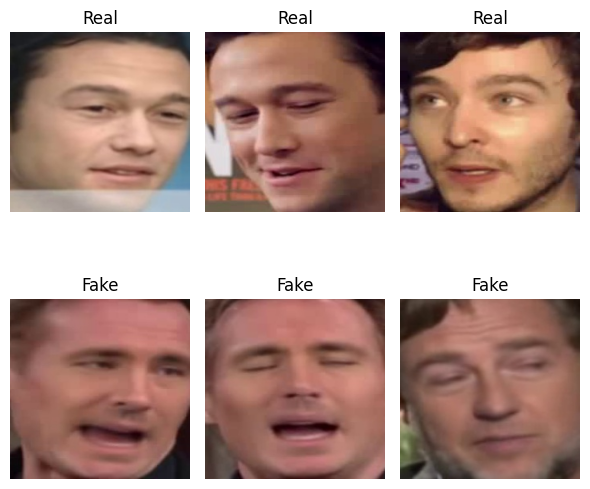

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
import os
from glob import glob

# Get all images
real_images = glob(os.path.join(output_dir, "Celeb-real", "*.jpg"))
fake_images = glob(os.path.join(output_dir, "Celeb-synthesis", "*.jpg"))

# Ensure we have at least 2 real and 2 fake images
if len(real_images) < 2 or len(fake_images) < 2:
    print("Not enough images found in the dataset. Check preprocessing steps.")
else:
    # Select 2 random images from each category
    sample_real = random.sample(real_images, 3)
    sample_fake = random.sample(fake_images, 3)

    # Combine for display
    sample_images = sample_real + sample_fake
    labels = ["Real", "Real", "Real", "Fake", "Fake", "Fake"]

    # Plot images in a 3x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))
    for ax, img_path, label in zip(axes.flatten(), sample_images, labels):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
!zip -r /content/celeb-df-v2_Q1.zip /content/Celeb-DF-Processed/

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
data_dir = "/content/Celeb-DF-Processed"  # Change this to your dataset directory
real_dir = os.path.join(data_dir, "Celeb-real")
fake_dir = os.path.join(data_dir, "Celeb-synthesis")

# Data Augmentation (Prevents Overfitting)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transforms)

# Split into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Load Pretrained EfficientNet-B7
model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features  # Get input features for the final layer
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # Binary classification (Real vs Fake)
)
model = model.to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Weight decay for regularization

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You 

In [7]:
# Training Loop
num_epochs = 1
early_stopping_patience = 5
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Learning rate adjustment
    scheduler.step()

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training.")
            break

print("Training Complete. Best model saved as 'best_model.pth'.")

Epoch 1/1 - Train Loss: 0.3918, Train Acc: 0.8626, Val Loss: 0.2742, Val Acc: 0.8939
Training Complete. Best model saved as 'best_model.pth'.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


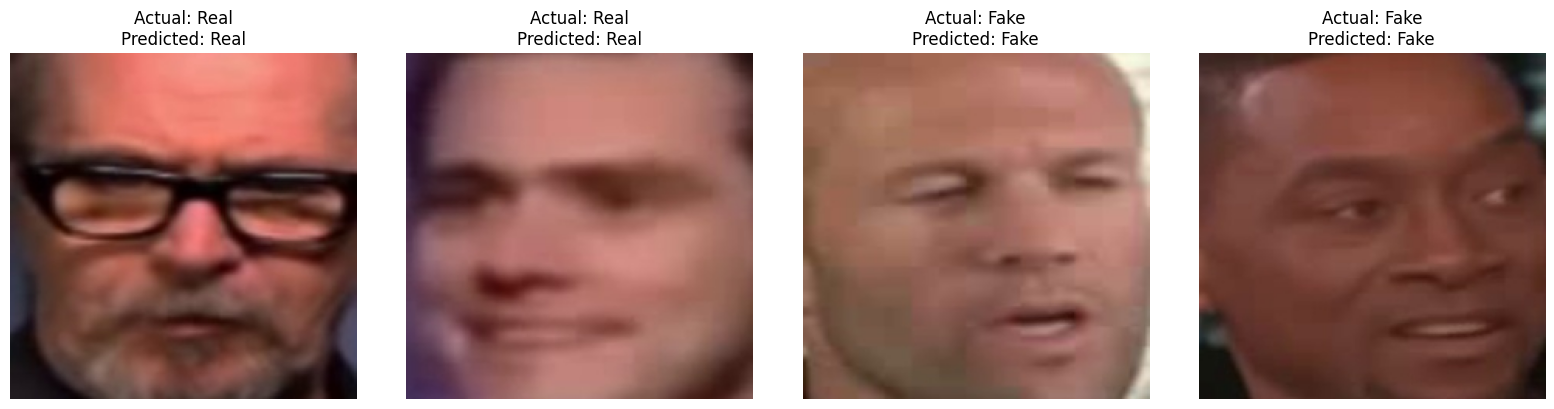

In [8]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b7(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 2)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# Define label mappings
class_labels = {0: "Real", 1: "Fake"}

# Image Transformations (Same as Validation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset Paths
data_dir = "/content/Celeb-DF-Processed"  # Change to your dataset directory
real_dir = os.path.join(data_dir, "Celeb-real")
fake_dir = os.path.join(data_dir, "Celeb-synthesis")

# Select 2 Real and 2 Fake Images
real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)[:2]]
fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)[:2]]

sample_images = real_images + fake_images
actual_labels = ["Real", "Real", "Fake", "Fake"]

# Predict and Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, img_path in enumerate(sample_images):
    image = Image.open(img_path).convert("RGB")  # Load image
    input_tensor = transform(image).unsqueeze(0).to(device)  # Apply transformations

    # Model Prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    predicted_label = class_labels[predicted_class]

    # Plot Image with Labels
    axes[idx].imshow(image)
    axes[idx].set_title(f"Actual: {actual_labels[idx]}\nPredicted: {predicted_label}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()
